In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox, chi2_contingency
from scipy.special import inv_boxcox

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import pickle

from common.utils import *

pd.options.display.max_rows = 200

In [3]:
train_data = pd.read_csv('../data/Crop_Data__train.csv')

In [4]:
df = train_data.copy()

In [5]:
# Track columns which need to be dropped
cols_to_drop = []

# Yield = Boxcox(Yield)

In [6]:
df, lmda = convert_to_yield(df, to_boxcox=True)

In [7]:
df.head()

,State,District,Lat,Long,GW_depth_Min,GW_depth_Max,Wells_depth_0_to_2,Wells_depth_2_to_5,Wells_depth_5_to_10,Wells_depth_10_to_20,...,Temp_Max,Temp_Min,Dew_Frost_Point,Wind_Speed,Year,Season,Crop,Area,Production,Yield
0,KARNATAKA,BIDAR,14.54387,76.23089,3.65,20.30,0,4,7,6.0,...,31.448,19.958,16.594,3.268,2014,Whole Year,Coriander,76.0,26.0,0.260659
1,ASSAM,SIVASAGAR,26.82490,94.17820,1.94,7.19,2,1,1,0.0,...,24.642,12.838,9.638,0.518,2001,Rabi,Urad,399.0,222.0,0.369402
2,GUJARAT,VADODARA,22.27342,73.18848,3.05,37.90,0,4,17,10.0,...,31.816,24.144,23.304,2.984,2003,Kharif,Urad,13100.0,10700.0,0.469397
3,RAJASTHAN,DUNGARPUR,23.68344,73.82284,2.44,20.60,0,4,6,7.0,...,33.668,20.010,12.087,2.317,2006,Whole Year,Guar seed,1799.0,45.0,0.024451
4,ASSAM,TINSUKIA,27.47920,95.37184,0.14,4.90,1,5,2,0.0,...,30.314,19.018,15.793,0.290,2001,Whole Year,Potato,2605.0,16774.0,0.969133


In [8]:
print(f"Boxcox lambda - {lmda}")

Boxcox lambda - -0.8410188383945721


## Drop Production and Area

In [9]:
df = df.drop(['Production', 'Area'], axis=1)

# Categorical Columns

## Lat and Long

We must consider Lat and Long as categorical features to avoid any bias in prediction value. This is because numerical values of latitide and longitude do not quantify the production of crop but only provide information of geographical location.

In [10]:
df[['Lat', 'Long']].nunique()

Lat     459
Long    459
dtype: int64

**Pipeline Action**

Based on cluster analysis and EDA we can seggregate Lat and Long values into six regions.

In [11]:
with open('../Analysis_and_Data_Processing/latlong_custerer_6.pkl', 'rb') as f:
    lat_long_clusterer = pickle.load(f)

In [12]:
df = identify_geo_region(df, lat_long_clusterer)

In [13]:
df['Geo_Region'].value_counts().sort_index()

R0    34021
R1    37617
R2    25694
R3    30729
R4    15066
R5    21859
Name: Geo_Region, dtype: int64

In [14]:
df = df.drop(['Lat', 'Long'], axis=1)

In [15]:
cols_to_drop.append('Lat')
cols_to_drop.append('Long')

## State and District

In [16]:
df['State'].nunique()

30

In [17]:
df['District'].nunique()

516

**Pipeline Action**

We can drop State and District columns as they are well represented by Geo_Region clusters.

Also being categorical input with many unique values, State and District would increase the feature set a lot.

In [18]:
df = df.drop(['State', 'District'], axis=1)

cols_to_drop.append('State')
cols_to_drop.append('District')

## Geo_Region

In [19]:
df['Geo_Region'].value_counts()

R1    37617
R0    34021
R3    30729
R2    25694
R5    21859
R4    15066
Name: Geo_Region, dtype: int64

<AxesSubplot:xlabel='Geo_Region', ylabel='Yield'>

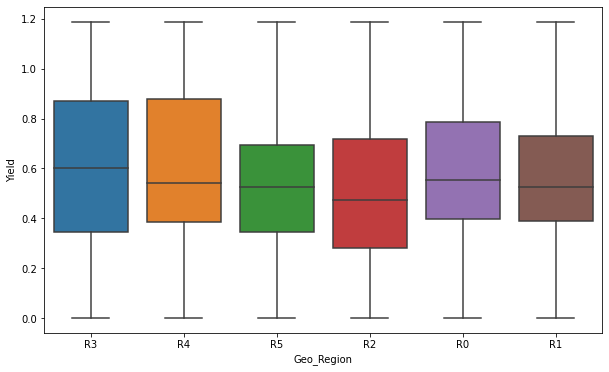

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Yield', x='Geo_Region', data=df)

In [21]:
# ANOVA test with Yield
anova_result = smf.ols(formula='Yield ~ C(Geo_Region)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     505.5
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:24:04   Log-Likelihood:                -27097.
No. Observations:              164986   AIC:                         5.421e+04
Df Residuals:                  164980   BIC:                         5.427e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5946      0.002    384.580      0.000       0.592       0.598
C(Geo_Region)[T.R1]    -0.0170      0.002     -7.954      0.000      -0.021      -0.013
C(Geo_Region)[T.R2]    -0.0702      0.002    -29.794      0.000      -0.075      -0.066
C(Geo_Region)[T.R3]     0.0238      0.002     10.587      0.000       0.019       0.028
C(Geo_Region)[T.R4]     0.0311      0.003     11.137      0.000       0.026       0.037
C(Geo_Region)[T.R5]    -0.0584      0.002    -23.636      0.000      -0.063      -0.054
==============================================================================
Omnibus:                    11094.221   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6657.865
Skew:                           0.357   Prob(JB):                         0.00
Kurtosis:                       2.324   Cond. No.                         6.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Season

In [22]:
df['Season'].value_counts()

Kharif        63382
Rabi          44262
Whole Year    39085
Summer        10731
Winter         4180
Autumn         3346
Name: Season, dtype: int64

<AxesSubplot:xlabel='Season', ylabel='Yield'>

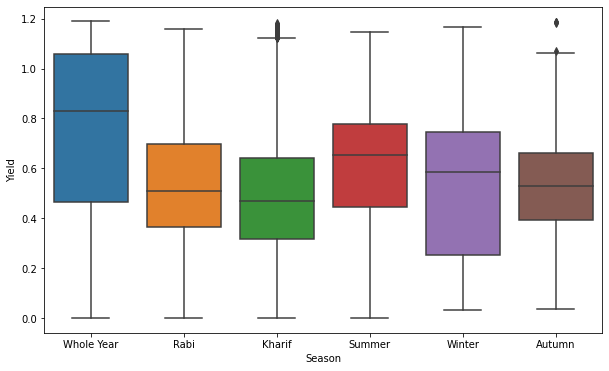

In [23]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Yield', x='Season', data=df)

In [24]:
# ANOVA test with Yield
anova_result = smf.ols(formula='Yield ~ C(Season)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     4620.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:24:06   Log-Likelihood:                -17540.
No. Observations:              164986   AIC:                         3.509e+04
Df Residuals:                  164980   BIC:                         3.515e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.5182      0.005    111.378      0.000       0.509       0.527
C(Season)[T.Kharif]        -0.0205      0.005     -4.289      0.000      -0.030      -0.011
C(Season)[T.Rabi]           0.0222      0.005      4.592      0.000       0.013       0.032
C(Season)[T.Summer]         0.1083      0.005     20.322      0.000       0.098       0.119
C(Season)[T.Whole Year]     0.2323      0.005     47.922      0.000       0.223       0.242
C(Season)[T.Winter]         0.0382      0.006      6.119      0.000       0.026       0.050
==============================================================================
Omnibus:                     1353.208   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              912.938
Skew:                           0.037   Prob(JB):                    5.73e-199
Kurtosis:                       2.643   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Crop

In [25]:
df['Crop'].nunique()

86

In [26]:
# ANOVA test with Yield
anova_result = smf.ols(formula='Yield ~ C(Crop)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     4466.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:24:10   Log-Likelihood:                 70186.
No. Observations:              164986   AIC:                        -1.402e+05
Df Residuals:                  164900   BIC:                        -1.393e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.5806      0.041     14.216      0.000       0.501       0.661
C(Crop)[T.Arecanut]                      0.0102      0.041      0.247      0.805      -0.070       0.091
C(Crop)[T.Arhar/Tur]                    -0.1473      0.041     -3.601      0.000      -0.227      -0.067
C(Crop)[T.Atcanut (Raw)]                 0.3708      0.056      6.618      0.000       0.261       0.481
C(Crop)[T.Bajra]                        -0.0516      0.041     -1.261      0.207      -0.132       0.029
C(Crop)[T.Banana]                        0.4960      0.041     12.105      0.000       0.416       0.576
C(Crop)[T.Barley]                        0.0830      0.041      2.026      0.043       0.003       0.163
C(Crop)[T.Beans & Mutter(Vegetable)]    -0.0943      0.043     -2.170      0.030      -0.179      -0.009
C(Crop)[T.Bhindi]                       -0.1453      0.042     -3.418      0.001      -0.229      -0.062
C(Crop)[T.Black pepper]                 -0.1280      0.041     -3.102      0.002      -0.209      -0.047
C(Crop)[T.Blackgram]                    -0.1534      0.047     -3.288      0.001      -0.245      -0.062
C(Crop)[T.Brinjal]                       0.0958      0.042      2.282      0.022       0.014       0.178
C(Crop)[T.Cabbage]                      -0.1223      0.043     -2.851      0.004      -0.206      -0.038
C(Crop)[T.Cardamom]                     -0.4980      0.042    -11.872      0.000      -0.580      -0.416
C(Crop)[T.Cashewnut]                    -0.2664      0.041     -6.463      0.000      -0.347      -0.186
C(Crop)[T.Cashewnut Processed]          -0.4935      0.055     -9.033      0.000      -0.601      -0.386
C(Crop)[T.Cashewnut Raw]                -0.2591      0.050     -5.181      0.000      -0.357      -0.161
C(Crop)[T.Castor seed]                  -0.2063      0.041     -5.037      0.000      -0.287      -0.126
C(Crop)[T.Citrus Fruit]                 -0.0982      0.042     -2.330      0.020      -0.181      -0.016
C(Crop)[T.Coconut ]                      0.4556      0.041     11.097      0.000       0.375       0.536
C(Crop)[T.Coffee]                       -0.1636      0.089     -1.838      0.066      -0.338       0.011
C(Crop)[T.Colocosia]                     0.4439      0.163      2.717      0.007       0.124       0.764
C(Crop)[T.Coriander]                    -0.2578      0.041     -6.294      0.000      -0.338      -0.178
C(Crop)[T.Cotton(lint)]                 -0.0037      0.041     -0.091      0.928      -0.084       0.077
C(Crop)[T.Cowpea(Lobia)]                -0.2694      0.042     -6.470      0.000      -0.351      -0.188
C(Crop)[T.Drum Stick]                   -0.3363      0.044     -7.653      0.000      -0.422      -0.250
C(Crop)[T.Dry chillies]               

In [27]:
# Chi2 test
chi2_contingency(pd.crosstab(df['Crop'], df['Season']))

(229108.24088680575,
 0.0,
 425,
 array([[3.04207630e-01, 5.76248894e+00, 4.02415963e+00, 9.75628235e-01,
         3.55348333e+00, 3.80032245e-01],
        [2.28764138e+01, 4.33339168e+02, 3.02616804e+02, 7.33672433e+01,
         2.67221946e+02, 2.85784248e+01],
        [1.09616149e+02, 2.07641685e+03, 1.45003885e+03, 3.51551374e+02,
         1.28043849e+03, 1.36938286e+02],
        [3.44768647e-01, 6.53082080e+00, 4.56071424e+00, 1.10571200e+00,
         4.02728110e+00, 4.30703211e-01],
        [8.21766210e+01, 1.55664035e+03, 1.08705965e+03, 2.63549707e+02,
         9.59914296e+02, 1.02659377e+02],
        [4.59556326e+01, 8.70519996e+02, 6.07916381e+02, 1.47384905e+02,
         5.36812881e+02, 5.74102045e+01],
        [5.87323530e+01, 1.11254453e+03, 7.76931085e+02, 1.88361291e+02,
         6.86059181e+02, 7.33715588e+01],
        [2.31197799e+00, 4.37949159e+01, 3.05836132e+01, 7.41477459e+00,
         2.70064733e+01, 2.88824506e+00],
        [3.67077207e+00, 6.95340332e+01, 4.8558

Ideally crops are very much dependent on season. p-value of chi2 test validates this.

**X - Pipeline Action (Discarded due to loss of information in clusters of crop)**

As per custer analysis and EDA, we can reduce the feature set by clustering both Season and Crop columns as Crop_Type.

In [28]:
with open('../Analysis_and_Data_Processing/crop_season_clusterer_6.pkl', 'rb') as f:
    crop_season_clusterer = pickle.load(f)

In [29]:
df = identify_crop_types(df, crop_season_clusterer)

In [30]:
df['Crop_Type'].value_counts().sort_index()

C0     7525
C1    37025
C2    44262
C3    63382
C4     2061
C5    10731
Name: Crop_Type, dtype: int64

In [31]:
# ANOVA test with Yield
anova_result = smf.ols(formula='Yield ~ C(Crop_Type)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     5950.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:24:12   Log-Likelihood:                -14674.
No. Observations:              164986   AIC:                         2.936e+04
Df Residuals:                  164980   BIC:                         2.942e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.5394      0.003    176.917      0.000       0.533       0.545
C(Crop_Type)[T.C1]     0.2353      0.003     70.343      0.000       0.229       0.242
C(Crop_Type)[T.C2]     0.0009      0.003      0.281      0.779      -0.006       0.007
C(Crop_Type)[T.C3]    -0.0417      0.003    -12.931      0.000      -0.048      -0.035
C(Crop_Type)[T.C4]    -0.2235      0.007    -33.984      0.000      -0.236      -0.211
C(Crop_Type)[T.C5]     0.0871      0.004     21.892      0.000       0.079       0.095
==============================================================================
Omnibus:                      415.029   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.038
Skew:                           0.016   Prob(JB):                     2.15e-72
Kurtosis:                       2.783   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Year

**Pipeline Action**

We must drop Year column to avoid the prediction dependency on Year.

In [32]:
df = df.drop('Year', axis=1)

# Numerical Columns

## Normalize numerical features

In [33]:
for col in ['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed']:
    df[col] = preprocessing.minmax_scale(df[col], feature_range=(1,2))

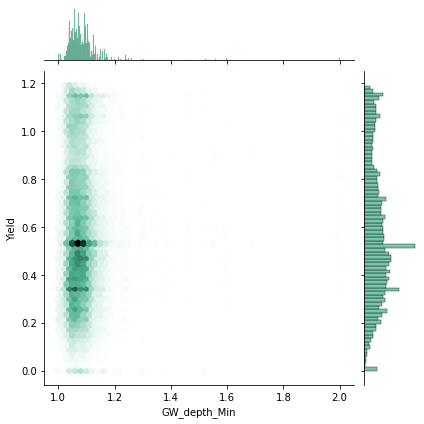

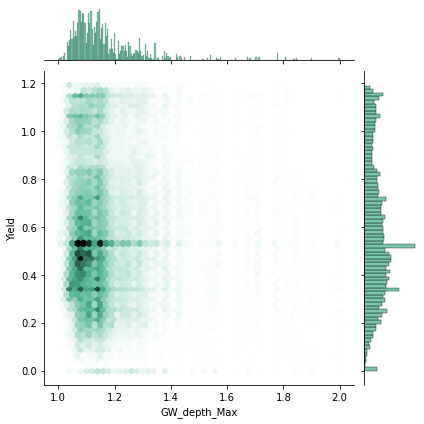

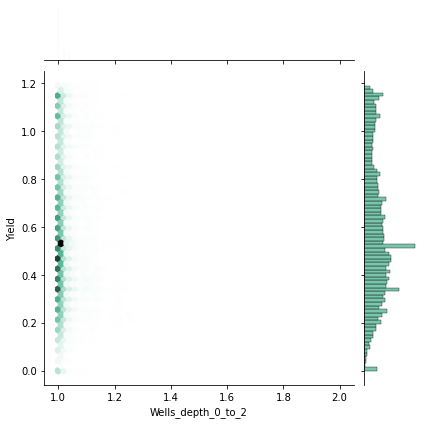

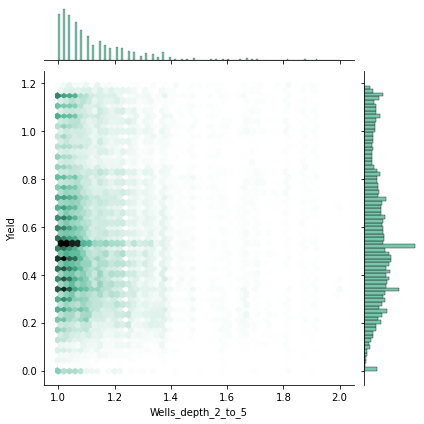

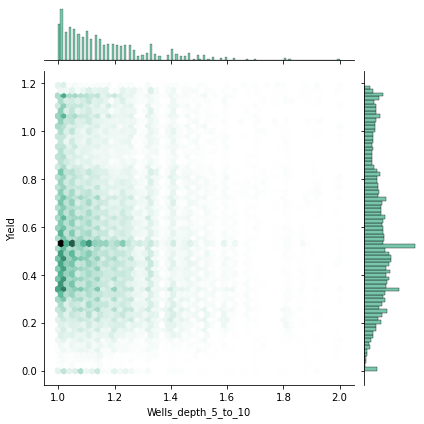

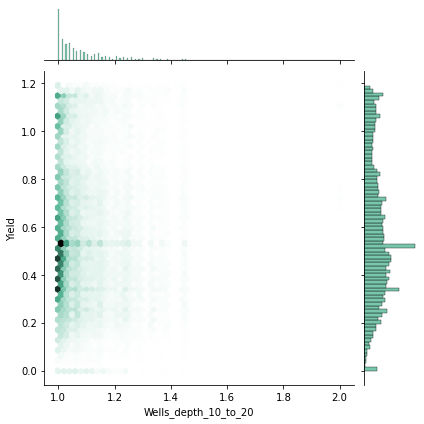

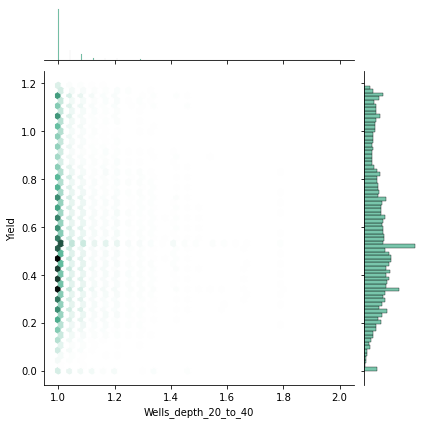

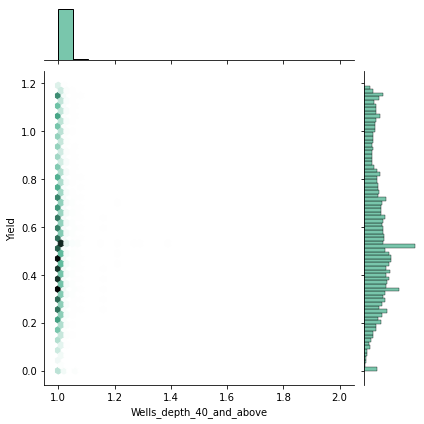

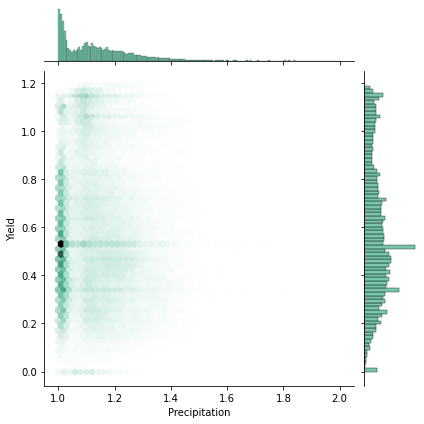

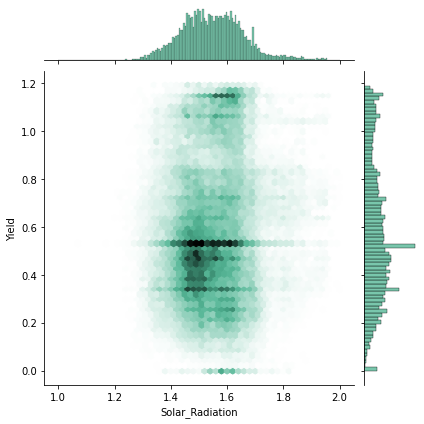

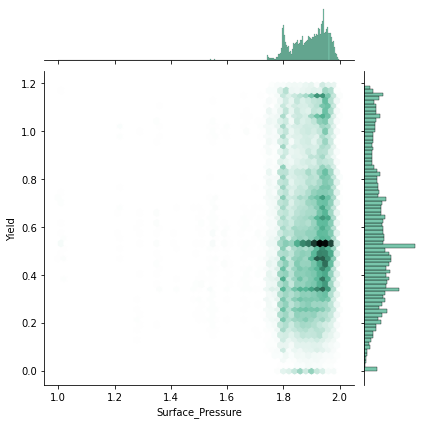

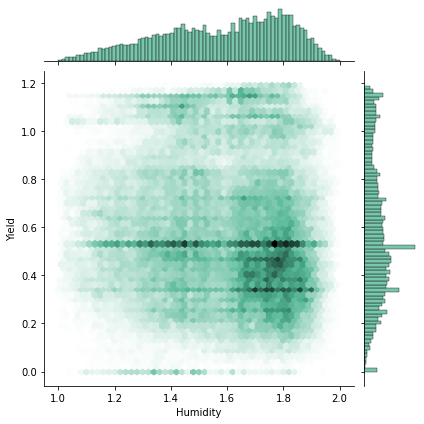

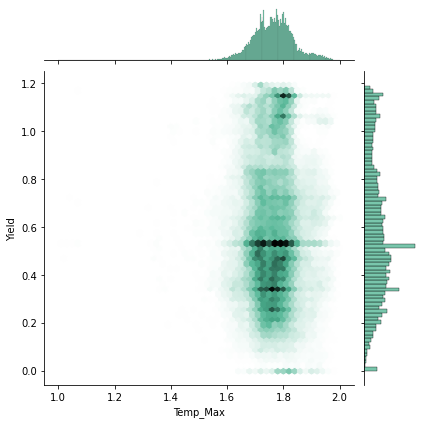

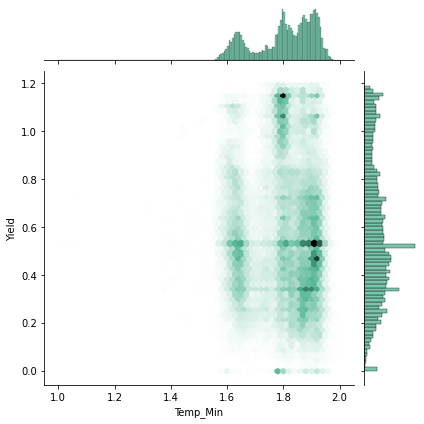

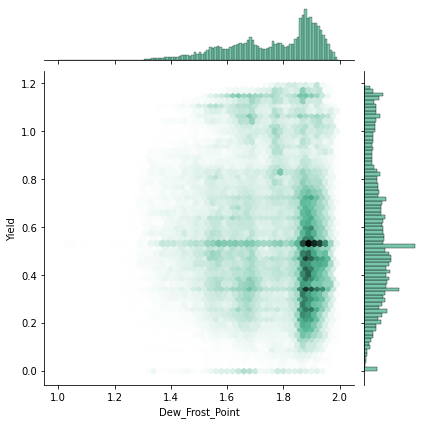

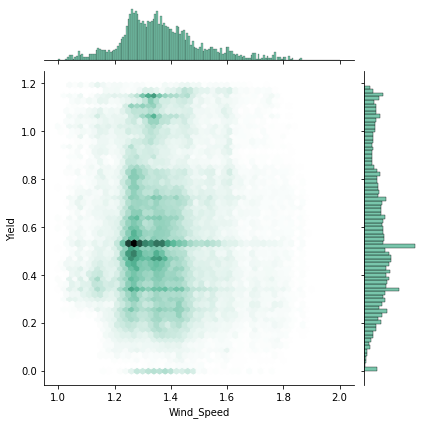

In [34]:
# Yield vs columns
for col in ['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed']:
    sns.jointplot(x=col, y='Yield', data=df, kind="hex", color="#4CB391")
    plt.xlabel(col)
    plt.ylabel('Yield = BoxCox(Yield)')
    plt.show()



boxcox-GW_depth_Min vs. Yield = BoxCox(Yield)


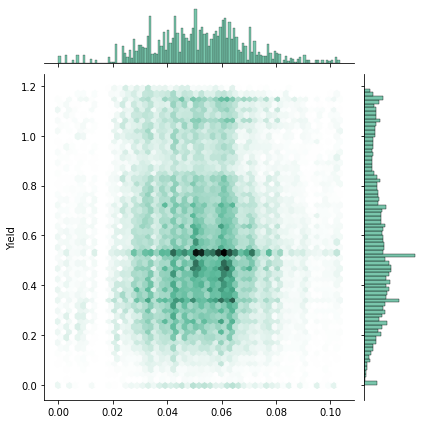



boxcox-GW_depth_Max vs. Yield = BoxCox(Yield)


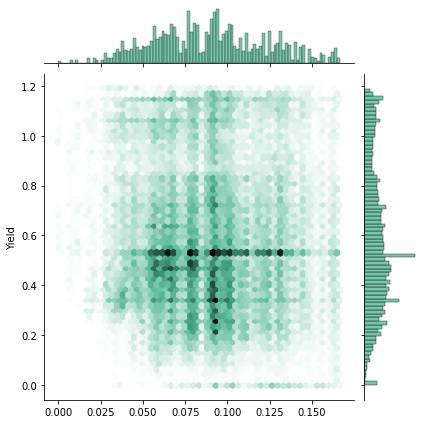



boxcox-Wells_depth_0_to_2 vs. Yield = BoxCox(Yield)


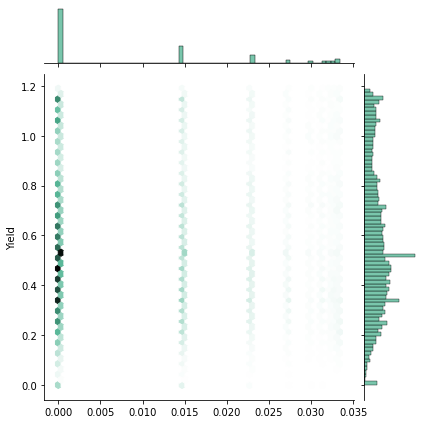



boxcox-Wells_depth_2_to_5 vs. Yield = BoxCox(Yield)


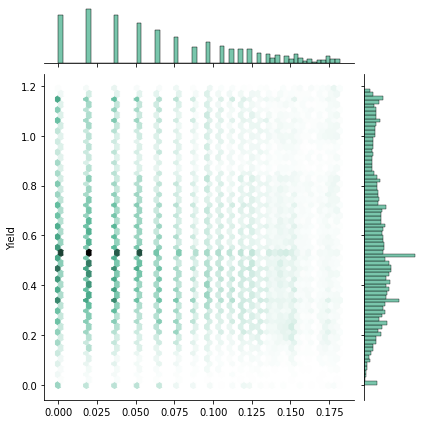



boxcox-Wells_depth_5_to_10 vs. Yield = BoxCox(Yield)


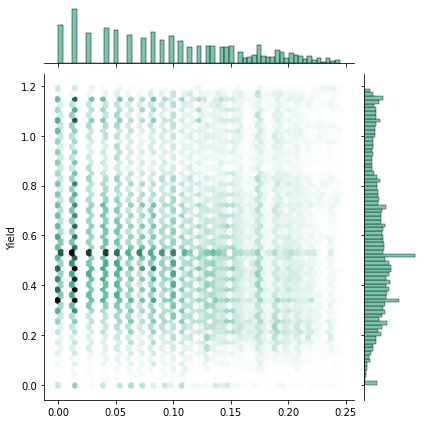



boxcox-Wells_depth_10_to_20 vs. Yield = BoxCox(Yield)


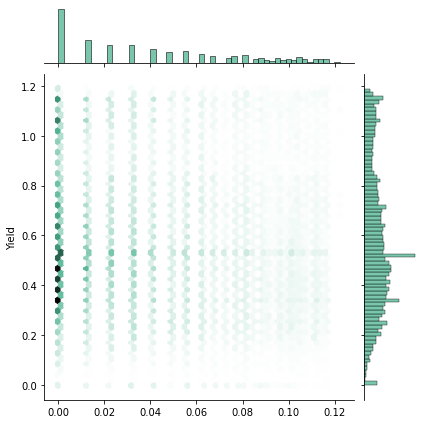



boxcox-Wells_depth_20_to_40 vs. Yield = BoxCox(Yield)


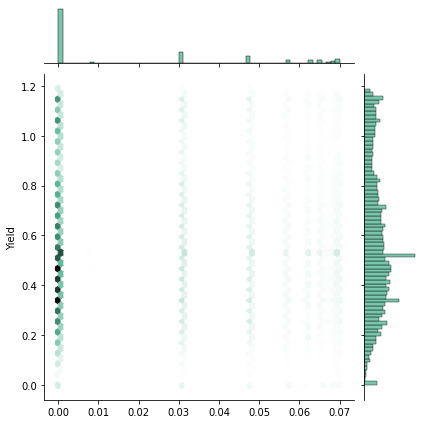



boxcox-Wells_depth_40_and_above vs. Yield = BoxCox(Yield)


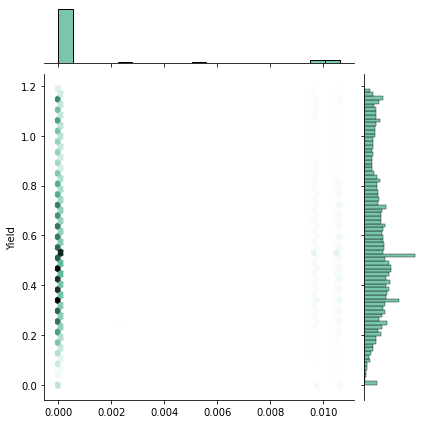



boxcox-Precipitation vs. Yield = BoxCox(Yield)


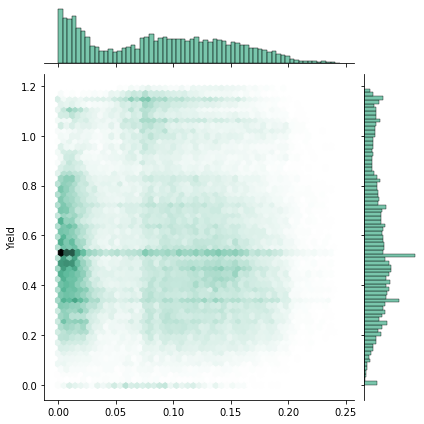



boxcox-Solar_Radiation vs. Yield = BoxCox(Yield)


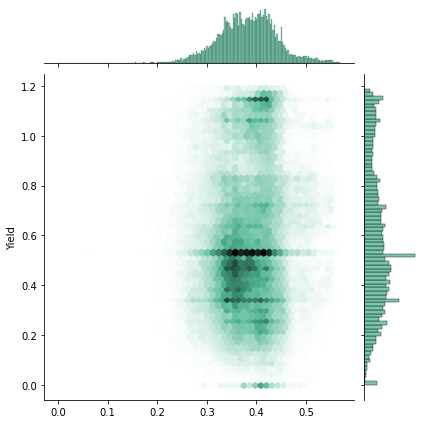



boxcox-Surface_Pressure vs. Yield = BoxCox(Yield)


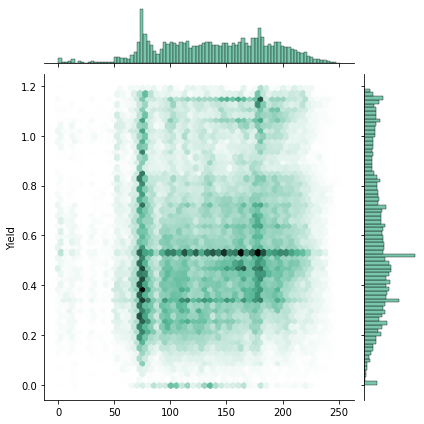



boxcox-Humidity vs. Yield = BoxCox(Yield)


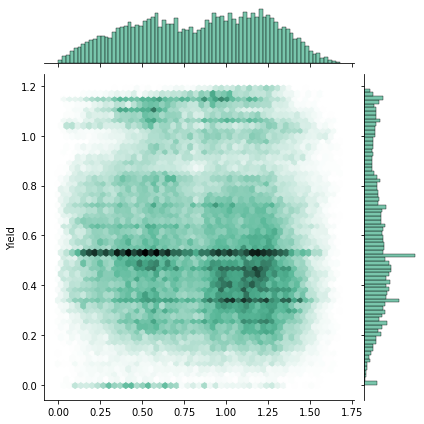



boxcox-Temp_Max vs. Yield = BoxCox(Yield)


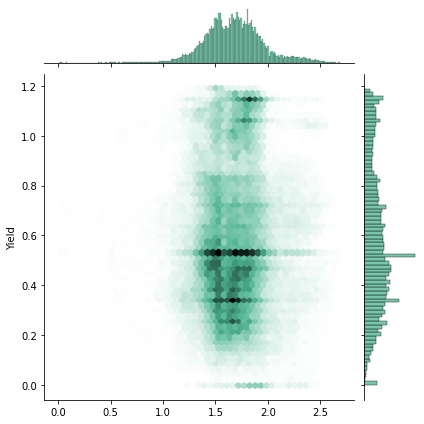



boxcox-Temp_Min vs. Yield = BoxCox(Yield)


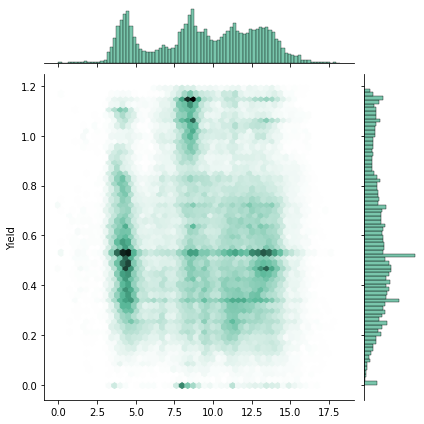



boxcox-Dew_Frost_Point vs. Yield = BoxCox(Yield)


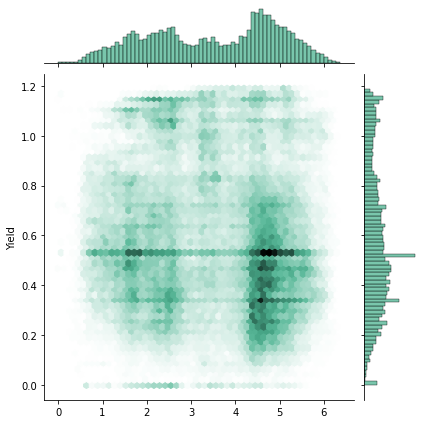



boxcox-Wind_Speed vs. Yield = BoxCox(Yield)


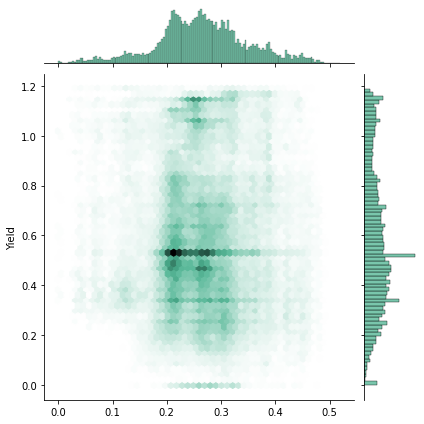

In [35]:
# Yield vs boxcox-columns
for col in ['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed']:
    print(f'\n\nboxcox-{col} vs. Yield = BoxCox(Yield)')
    sns.jointplot(x=boxcox(df[col])[0], y=df['Yield'], kind="hex", color="#4CB391")
    plt.show()

## Correlation

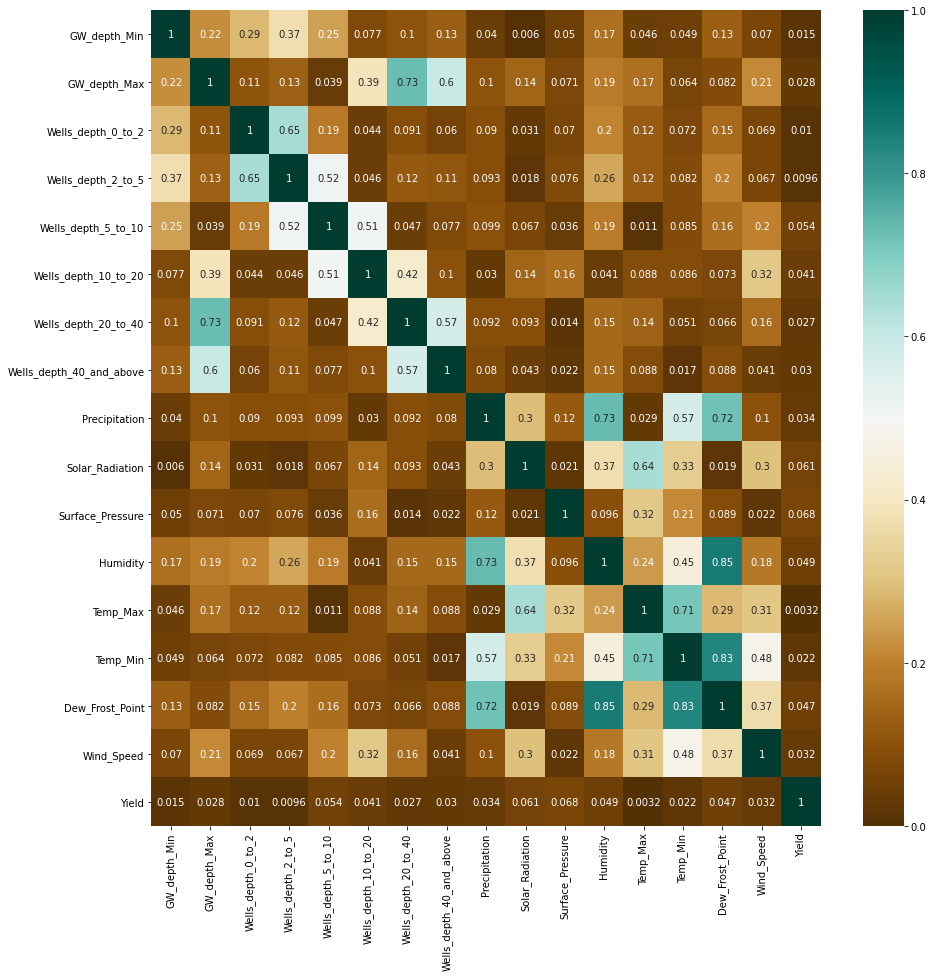

In [36]:
df_for_corr = df.select_dtypes(exclude='object').copy()

plt.figure(figsize=(15,15))
sns.heatmap(df_for_corr.corr().abs(), annot=True, vmin=0, vmax=1, cmap=plt.cm.BrBG)
plt.show()

**Note**

Taking correlation cut-off as 80.

We find following as highly correlated features:
1. Humidity vs. Dew_Frost_Point
2. Temp_Min vs Dew_Frost_Point

**Pipeline Action**

Drop column Dew_Frost_Point due to high correlation (above 80)

In [37]:
# Drop Dew_Frost_Point due to high correlation
df = df.drop('Dew_Frost_Point', axis=1)

print(df.shape)
print(df.columns)

(164986, 20)
Index(['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Wind_Speed', 'Season', 'Crop', 'Yield', 'Geo_Region',
       'Crop_Type'],
      dtype='object')


## ANOVA test for Crop, Season and Geo_Region

In [38]:
model = smf.ols('Yield ~ Crop', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

model = smf.ols('Yield ~ Season', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

model = smf.ols('Yield ~ Geo_Region', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

model = smf.ols('Yield ~ Crop + Season', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

model = smf.ols('Yield ~ Crop + Season + Geo_Region', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

               sum_sq        df            F  PR(>F)
Crop      9496.207649      85.0  4465.645724     0.0
Residual  4125.415220  164900.0          NaN     NaN



                sum_sq        df            F  PR(>F)
Season     1673.070014       5.0  4620.192827     0.0
Residual  11948.552855  164980.0          NaN     NaN



                  sum_sq        df           F  PR(>F)
Geo_Region    205.521993       5.0  505.467553     0.0
Residual    13416.100877  164980.0         NaN     NaN



               sum_sq        df            F  PR(>F)
Crop      7957.781877      85.0  3868.332414     0.0
Season     134.644242       5.0  1112.675337     0.0
Residual  3990.770979  164895.0          NaN     NaN



                 sum_sq        df            F  PR(>F)
Crop        7882.452963      85.0  3892.958101     0.0
Season       129.047290       5.0  1083.468161     0.0
Geo_Region    62.901476       5.0   528.114508     0.0
Residual    3927.869503  164890.0          NaN     NaN





Above results of ANOVA test shows that Crop, Season and Geo_Region have significant impact on Yield.

# Feature Importance

## Analysis using OLS

In [39]:
def ols_summary(cols, Yield, data):
    formula_str = f"{Yield} ~ "
    for col in cols:
        formula_str += f" + {col}"
    return smf.ols(formula=formula_str, data=data).fit().summary()

In [40]:
ols_summary(['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Wind_Speed', 'C(Crop)', 'C(Season)', 'C(Geo_Region)'], 'Yield', df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     3907.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:25:13   Log-Likelihood:                 77471.
No. Observations:              164986   AIC:                        -1.547e+05
Df Residuals:                  164875   BIC:                        -1.536e+05
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.5919      0.048     12.352      0.000       0.498       0.686
C(Crop)[T.Arecanut]                     -0.0156      0.039     -0.396      0.692      -0.093       0.062
C(Crop)[T.Arhar/Tur]                    -0.1735      0.039     -4.428      0.000      -0.250      -0.097
C(Crop)[T.Atcanut (Raw)]                 0.3651      0.054      6.809      0.000       0.260       0.470
C(Crop)[T.Bajra]                        -0.0859      0.039     -2.193      0.028      -0.163      -0.009
C(Crop)[T.Banana]                        0.4736      0.039     12.075      0.000       0.397       0.550
C(Crop)[T.Barley]                       -0.0146      0.039     -0.373      0.709      -0.092       0.062
C(Crop)[T.Beans & Mutter(Vegetable)]    -0.0913      0.042     -2.196      0.028      -0.173      -0.010
C(Crop)[T.Bhindi]                       -0.1569      0.041     -3.856      0.000      -0.237      -0.077
C(Crop)[T.Black pepper]                 -0.1654      0.040     -4.185      0.000      -0.243      -0.088
C(Crop)[T.Blackgram]                    -0.1980      0.045     -4.429      0.000      -0.286      -0.110
C(Crop)[T.Brinjal]                       0.0703      0.040      1.751      0.080      -0.008       0.149
C(Crop)[T.Cabbage]                      -0.1335      0.041     -3.250      0.001      -0.214      -0.053
C(Crop)[T.Cardamom]                     -0.5445      0.040    -13.556      0.000      -0.623      -0.466
C(Crop)[T.Cashewnut]                    -0.3123      0.039     -7.915      0.000      -0.390      -0.235
C(Crop)[T.Cashewnut Processed]          -0.4952      0.052     -9.472      0.000      -0.598      -0.393
C(Crop)[T.Cashewnut Raw]                -0.2863      0.048     -5.980      0.000      -0.380      -0.192
C(Crop)[T.Castor seed]                  -0.2313      0.039     -5.895      0.000      -0.308      -0.154
C(Crop)[T.Citrus Fruit]                 -0.0975      0.040     -2.417      0.016      -0.177      -0.018
C(Crop)[T.Coconut ]                      0.4330      0.039     11.018      0.000       0.356       0.510
C(Crop)[T.Coffee]                       -0.2017      0.085     -2.368      0.018      -0.369      -0.035
C(Crop)[T.Colocosia]                     0.4789      0.156      3.064      0.002       0.173       0.785
C(Crop)[T.Coriander]                    -0.2773      0.039     -7.072      0.000      -0.354      -0.200
C(Crop)[T.Cotton(lint)]                 -0.0299      0.039     -0.762      0.446      -0.107       0.047
C(Crop)[T.Cowpea(Lobia)]                -0.3234      0.040     -8.112      0.000      -0.402      -0.245
C(Crop)[T.Drum Stick]                   -0.3963      0.042     -9.419      0.000      -0.479      -0.314
C(Crop)[T.Dry chillies]               

In [41]:
ols_summary(['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Wind_Speed', 'C(Crop_Type)', 'C(Geo_Region)'], 'Yield', df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     1432.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:25:14   Log-Likelihood:                -12152.
No. Observations:              164986   AIC:                         2.436e+04
Df Residuals:                  164960   BIC:                         2.462e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.6668      0.045     14.841      0.000       0.579       0.755
C(Crop_Type)[T.C1]           0.2662      0.004     63.275      0.000       0.258       0.274
C(Crop_Type)[T.C2]          -0.0009      0.004     -0.248      0.804      -0.008       0.006
C(Crop_Type)[T.C3]          -0.0045      0.005     -0.885      0.376      -0.015       0.005
C(Crop_Type)[T.C4]          -0.1768      0.007    -25.153      0.000      -0.191      -0.163
C(Crop_Type)[T.C5]           0.1499      0.006     25.187      0.000       0.138       0.162
C(Geo_Region)[T.R1]         -0.0376      0.002    -15.674      0.000      -0.042      -0.033
C(Geo_Region)[T.R2]         -0.0642      0.003    -22.226      0.000      -0.070      -0.059
C(Geo_Region)[T.R3]         -0.0212      0.003     -6.374      0.000      -0.028      -0.015
C(Geo_Region)[T.R4]         -0.0409      0.004    -11.273      0.000      -0.048      -0.034
C(Geo_Region)[T.R5]         -0.0769      0.003    -26.281      0.000      -0.083      -0.071
GW_depth_Min                 0.0479      0.011      4.492      0.000       0.027       0.069
GW_depth_Max                -0.0175      0.008     -2.133      0.033      -0.034      -0.001
Wells_depth_0_to_2          -0.1863      0.016    -11.973      0.000      -0.217      -0.156
Wells_depth_2_to_5           0.0846      0.006     13.077      0.000       0.072       0.097
Wells_depth_5_to_10         -0.1477      0.006    -25.844      0.000      -0.159      -0.137
Wells_depth_10_to_20         0.0791      0.009      8.816      0.000       0.061       0.097
Wells_depth_20_to_40         0.0740      0.008      8.801      0.000       0.058       0.091
Wells_depth_40_and_above    -0.1951      0.014    -14.402      0.000      -0.222      -0.169
Precipitation                0.1647      0.012     13.898      0.000       0.141       0.188
Solar_Radiation              0.0765      0.011      7.244      0.000       0.056       0.097
Surface_Pressure             0.4312      0.012     35.158      0.000       0.407       0.455
Humidity                    -0.0233      0.010     -2.426      0.015      -0.042      -0.004
Temp_Max                    -0.4278      0.032    -13.323      0.000      -0.491      -0.365
Temp_Min                    -0.1163      0.029     -3.981      0.000      -0.174      -0.059
Wind_Speed                   0.0254      0.009      2.961      0.003       0.009       0.042
==============================================================================
Omnibus:                      322.198   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.751
Skew:                           0.004   Prob(JB):                     1.45e-57
Kurtosis:                       2.805   Cond. No.                     

### Identify cols which need boxcox transformation

In [42]:
# This function find those columns which show improvement in Adj. R-squared value upon boxcox transformation
def get_boxcox_cols(data, Yield, numerical_cols, categorical_cols=[]):
    cols = [*numerical_cols, *categorical_cols]
    
    # Scale data
#     data[numerical_cols] = preprocessing.minmax_scale(data[numerical_cols], feature_range=(1,2))
    
    max_rsquared_adj = 0
    boxcox_cols = []
    
    # Adj. R-squared without boxcox transformation
    formula_str = f"{Yield} ~ "
    for col in cols:
        formula_str += f" + {col}"
    max_rsquared_adj = smf.ols(formula=formula_str, data=data).fit().rsquared_adj
    
    print(f"Base R2 score = {max_rsquared_adj}")
    
    improvement_log = [max_rsquared_adj]
    
    # Calculate boxcox for each numerical column
    for col in numerical_cols:
        data[f'boxcox_{col}'] = boxcox(data[col])[0]
    
    # Check improvement in Adj. R-squared with boxcox transformation on each column
    for boxcox_col in cols:
        formula_str = f"{Yield} ~ "
        for col in cols:
            if (col not in categorical_cols) and (col == boxcox_col or (col in boxcox_cols)):
                formula_str += f" + boxcox_{col}"
            else:
                formula_str += f" + {col}"
        rsquared_adj = smf.ols(formula=formula_str, data=data).fit().rsquared_adj
        if max_rsquared_adj < rsquared_adj:
            boxcox_cols.append(boxcox_col)
            max_rsquared_adj = rsquared_adj
            improvement_log.append(rsquared_adj)
    return boxcox_cols, improvement_log

In [43]:
# get_boxcox_cols(df.copy(), 'Yield', ['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
#            'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
#            'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
#            'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
#            'Temp_Min', 'Wind_Speed'], ['C(Crop)', 'C(Season)', 'C(Geo_Region)'])

No other boxcox transformation is required because the improvement seen using transformed columns is very less.

## Analysis using Decision Tree Regressor

In [44]:
from sklearn.tree import DecisionTreeRegressor

In [45]:
def reg_summary(reg_model, inputs, target, with_split=True):
    X_train = inputs.select_dtypes(exclude='object').copy()
    X_train = pd.concat([X_train, pd.get_dummies(inputs.select_dtypes('object'))], axis=1)
    y_train = target.copy()
    
    if with_split == True:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
    
    print('X_train.shape: ' + str(X_train.shape))
    
    print(reg_model)

    reg_model.fit(X_train, y_train)
    
    print(f"Train score: {reg_model.score(X_train, y_train)}")
    if with_split == True:
        print(f"Test score: {reg_model.score(X_val, y_val)}")
    
    # reg.feature_importances_
    feature_scores = pd.DataFrame(X_train.columns, columns=['Feature'])
    feature_scores['Score'] = reg_model.feature_importances_
    
    return feature_scores

### Using Crop

In [46]:
reg = DecisionTreeRegressor()

reg_summary(reg, df.drop(['Crop_Type', 'Yield'], axis=1), df['Yield']).sort_values(by='Score')

X_train.shape: (131988, 113)
DecisionTreeRegressor()
Train score: 1.0
Test score: 0.8043584826734724


,Feature,Score
42,Crop_Colocosia,0.000000e+00
64,Crop_Lentil,6.319093e-07
60,Crop_Kapas,7.137745e-07
31,Crop_Blackgram,2.994526e-06
41,Crop_Coffee,4.429570e-06
24,Crop_Atcanut (Raw),1.266255e-05
87,Crop_Rubber,2.321117e-05
105,Crop_Varagu,2.926712e-05
89,Crop_Samai,4.157554e-05
62,Crop_Korra,4.705784e-05


Train vs. Test scores shows that DEcision Tree Regressor is overfitting.

### Using Crop_Type

In [47]:
reg = DecisionTreeRegressor()

reg_summary(reg, df.drop(['Crop', 'Yield'], axis=1), df['Yield']).sort_values(by='Score')

X_train.shape: (131988, 33)
DecisionTreeRegressor()
Train score: 0.39040674150949295
Test score: 0.06404852113812076


,Feature,Score
29,Crop_Type_C2,0.000119
16,Season_Kharif,0.000140
17,Season_Rabi,0.000343
25,Geo_Region_R4,0.000385
30,Crop_Type_C3,0.000474
15,Season_Autumn,0.000576
18,Season_Summer,0.000729
22,Geo_Region_R1,0.001165
20,Season_Winter,0.001456
7,Wells_depth_40_and_above,0.001878


Seems like Crop_Type could not explain much about Yield.

## Analysis using Random Forest Regressor

In [48]:
from sklearn.ensemble import RandomForestRegressor

### Using Crop

In [49]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1)

reg_summary(reg, df.drop(['Crop_Type', 'Yield'], axis=1), df['Yield']).sort_values(by='Score')

X_train.shape: (131988, 113)
RandomForestRegressor(n_estimators=15, n_jobs=-1)
Train score: 0.9823034912154565
Test score: 0.8944001797554558


,Feature,Score
42,Crop_Colocosia,0.000000e+00
60,Crop_Kapas,1.729948e-07
64,Crop_Lentil,5.310542e-07
41,Crop_Coffee,5.539289e-06
31,Crop_Blackgram,8.430244e-06
105,Crop_Varagu,3.629626e-05
87,Crop_Rubber,4.956624e-05
24,Crop_Atcanut (Raw),6.057203e-05
21,Crop_Arcanut (Processed),6.222314e-05
73,Crop_Oilseeds total,7.026886e-05


Train vs. Test scores shows that Random Forest Regressor is overfitting.

### Using Crop_Type

In [50]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1)

reg_summary(reg, df.drop(['Crop', 'Yield'], axis=1), df['Yield']).sort_values(by='Score')

X_train.shape: (131988, 33)
RandomForestRegressor(n_estimators=15, n_jobs=-1)
Train score: 0.379248777853767
Test score: 0.09256694143908073


,Feature,Score
16,Season_Kharif,0.000129
17,Season_Rabi,0.000199
30,Crop_Type_C3,0.000339
29,Crop_Type_C2,0.000408
25,Geo_Region_R4,0.000421
15,Season_Autumn,0.000473
20,Season_Winter,0.000819
26,Geo_Region_R5,0.002090
7,Wells_depth_40_and_above,0.002279
27,Crop_Type_C0,0.002382


**Observation**

From above results we see that Crop_Type is not explain the variance of Yield. Hence, we must not consider this feature and look for other representation of Crop column.

## Obtain X and y (Checkpoint)

In [51]:
X = df.drop(['Crop_Type', 'Yield'], axis=1)
y = df['Yield']

# Analysis of Crop feature using Categorical Encodings

In [52]:
import category_encoders as ce

## Target Encoding

In [53]:
target_encoder = ce.TargetEncoder()

In [54]:
X['Crop_Encoded'] = target_encoder.fit_transform(df['Crop'], df['Yield'])

/home/animathur/anaconda3/envs/py3-TF2/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [55]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)

reg_summary(reg, X.drop('Crop', axis=1), y)

X_train.shape: (131988, 28)
RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)
Train score: 0.981686213906799
Test score: 0.8912992115020433


,Feature,Score
0,GW_depth_Min,0.012711
1,GW_depth_Max,0.013502
2,Wells_depth_0_to_2,0.002590
3,Wells_depth_2_to_5,0.009336
4,Wells_depth_5_to_10,0.013741
5,Wells_depth_10_to_20,0.007544
6,Wells_depth_20_to_40,0.004821
7,Wells_depth_40_and_above,0.002279
8,Precipitation,0.016215
9,Solar_Radiation,0.019839


**Observation**

Importance of Crop_Encoded = 0.744395

## Leave One Out Encoding

In [56]:
loo_encoder = ce.LeaveOneOutEncoder()

In [57]:
X['Crop_Encoded'] = loo_encoder.fit_transform(df['Crop'], df['Yield'])

In [58]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)

reg_summary(reg, X.drop('Crop', axis=1), y)

X_train.shape: (131988, 28)
RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)
Train score: 0.9990872306438005
Test score: 0.9951529028388112


,Feature,Score
0,GW_depth_Min,0.000653
1,GW_depth_Max,0.000817
2,Wells_depth_0_to_2,0.000561
3,Wells_depth_2_to_5,0.001372
4,Wells_depth_5_to_10,0.001990
5,Wells_depth_10_to_20,0.000556
6,Wells_depth_20_to_40,0.000807
7,Wells_depth_40_and_above,0.000940
8,Precipitation,0.001856
9,Solar_Radiation,0.001764


**Observation**

1. Importance of Crop_Encoded = 0.942902
2. Seems like target is getting leaked.

## Encode using Weight of Evidence (WoE) for continuous target

In [59]:
woe = crop_woe(df, 'Yield')

Information Value: 16.664137163011237


In [60]:
X['Crop_Encoded'] = X['Crop'].apply(lambda x: woe[x])

In [61]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)

reg_summary(reg, X.drop('Crop', axis=1), y)

X_train.shape: (131988, 28)
RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)
Train score: 0.9816950882599849
Test score: 0.8918627304475673


,Feature,Score
0,GW_depth_Min,0.012685
1,GW_depth_Max,0.013421
2,Wells_depth_0_to_2,0.002679
3,Wells_depth_2_to_5,0.009276
4,Wells_depth_5_to_10,0.013802
5,Wells_depth_10_to_20,0.007517
6,Wells_depth_20_to_40,0.004724
7,Wells_depth_40_and_above,0.002298
8,Precipitation,0.016252
9,Solar_Radiation,0.019981


**Observation**

Importance of Crop_Encoded = 0.744308

**Note**

We see that training, testing and feature importance scores of Random Forest Regressor with same settings for Crop, Crop_Encoded for Target encoding and Crop_Encoded for WoE encoding are very similar.

**Pipeline Action**

We must use Weight of Evidence to encode the Crop column as it considers entire training set of Crops and do not consider direct correlation between Crop and Yield (avoiding target leakage).

# Pipeline for Input Features

We curate all preprocessing steps (Pipeline Actions) to construct a pipeline for input features to the model.